<h1>NIH Chest X-Ray Exploratory Analysis</h1>

<img src="notebook_images/co_occurrence.png">
<img src="notebook_images/disease_examples.png">

<h3> Introduction </h3>

<p>
    The goal of this notebook is to do some introductory data exploration and manipulation using the NIH Chest X-Ray database. The database is available via <a href="https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345">Box</a> and includes the whitepaper that accompanies the creation of the database.
</p>

<p>
    I'll try to go through and show some sample images as well as understand some of the pathology occurring within the patients to know what we might be looking for. In general the data is split into 14 categories of patient disease which can be identified via x-ray: 
</p>

<ol>
    <li>Atelectasis</li>
    <li>Cardiomegaly</li>
    <li>Effusion</li>
    <li>Infiltration</li>
    <li>Mass</li>
    <li>Nodule</li>
    <li>Pneumonia</li>
    <li>Pneumothorax</li>
    <li>Consolidation</li>
    <li>Edema</li>
    <li>Emphysema</li>
    <li>Fibrosis</li>
    <li>Pleural_Thickening</li>
    <li>Hernia</li>
</ol>

<p>
    A reasonable goal for a deep learning model unleashed on this dataset would of course be able to tell whether or not an x-ray contains signs of any of these diseases. Beyond that, there is an additional set of information for these patients that contains bounding boxes for specific regions of interest within an x-ray image. This would make for an interesting avenue of exploration once basic categorization is accomplished.
</p>

In [32]:
import tensorflow as tf
import keras

import os
import sys
import re
import glob
import PIL

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Image

<p>First thing to understand is the directory layout that will hold all of our images. We'll check what's in the current directory and then move from there.</p>

In [26]:
!ls

EDA.ipynb        download_zips.py notebook_images
data             info


<p>The main players in this folder are our data/ directory and the download_zips.py script. The download_zips.py script contains a series of links to each compressed image directory and puts them onto our machine. I've already extracted the images I'll be using, but the code for the download_zips.py script provided by NIH looks like this: 
    
    '''
    import urllib.request

    import sys
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context

    links = [
        'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
        'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
        'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
        'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
        'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',

        'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
        'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
        'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
        'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
        'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
        'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
        'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
    ]

    def prog_bar(count, blockSize, totalSize):
        percent = int(count*blockSize*100/totalSize)
        sys.stdout.write("\r%2d%%" % percent)
        sys.stdout.flush()

    for idx, link in enumerate(links):
        fn = 'data/images/images_%02d.tar.gz' % (idx+5)
        print('downloading', fn, '...')
        urllib.request.urlretrieve(link, fn, reporthook=prog_bar)  # download the zip file

    print("Download complete. Please check the checksums")

    '''
    
</p>

<p>Let's check out the data folder. The main layout is a couple of csv files used for labelling that we'll use Pandas to deal with along with the train_val_list and test_list .txt files. These explain which patients fall into the train category and which into the validation/test category. Since we are dealing with medical data and have about 30,000 patients comprising 112,000 x-rays we'll have multiple images per patient. This is perfectly acceptable as long as no patient appears in both sets, which these files allow us to avoid.</p>

In [24]:
!ls data

BBox_List_2017.csv  images              train_val_list.txt
Data_Entry_2017.csv test_list.txt


<p>Here we'll try to get a feel for the syntax of an actual x-ray image. We want to know the exact formulat for getting a specific xray so we'll just check out the first 10 images.</p>

In [25]:
!ls data/images/ | head

00000001_000.png
00000001_001.png
00000001_002.png
00000002_000.png
00000003_000.png
00000003_001.png
00000003_002.png
00000003_003.png
00000003_004.png
00000003_005.png


<p>Ok, let's see what these x-ray images actually look like. Who knows maybe we'll just be smart enough to not need a neural network...</p>

In [33]:
def show_single_xray(patient_no, xray_no):
    
    # Image file syntax:
    #     patient_no_xray_no.png
    # .   ^8 digits  ^3 digits
    
    patient_no_pad = "{:08d}".format(patient_no)
    xray_no_pad = "{:03d}".format(xray_no)
    
    patient_string = patient_no_pad + '_' + xray_no_pad + '.png'
    image_path = 'data/images/' + patient_string
    
    xray_image = PIL.Image.open(image_path)
    
    plt.figure(figsize=(10,10))
    
    plt.imshow(xray_image, cmap='gray')
    plt.axis('off')
    plt.title('Patient No. {} - Xray No. {}'.format(patient_no, xray_no))
    
    plt.show()

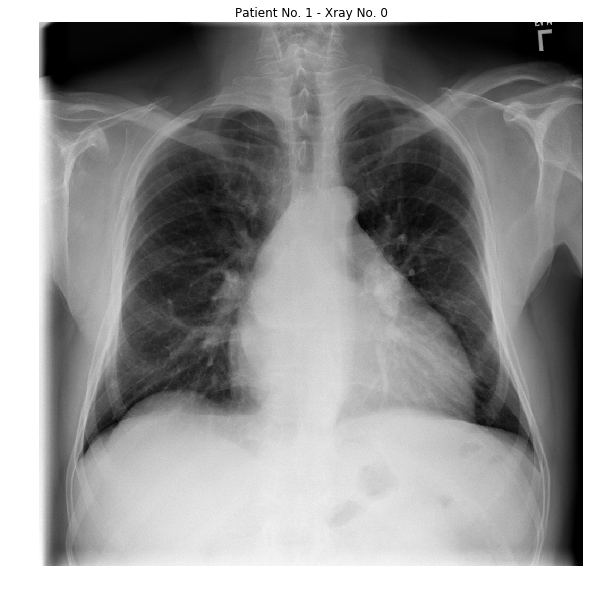

In [34]:
show_single_xray(1, 0)

In [50]:
def show_patient_xrays(patient_no):
    # Image file syntax:
    #     patient_no_xray_no.png
    # .   ^8 digits  ^3 digits
    
    patient_no_pad = "{:08d}".format(patient_no)    
    patient_base_path = 'data/images/' + patient_no_pad
    
    patient_xray_list = glob.glob(patient_base_path + '*')
    num_xrays = len(patient_xray_list)
        
    plt.subplots(figsize=(10,10))
    for ix, xray in enumerate(patient_xray_list):
        image = PIL.Image.open(xray)
        plt.subplot(num_xrays, 2, ix+1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
    plt.suptitle('Patient No. {} X-Rays'.format(patient_no))
    plt.show()

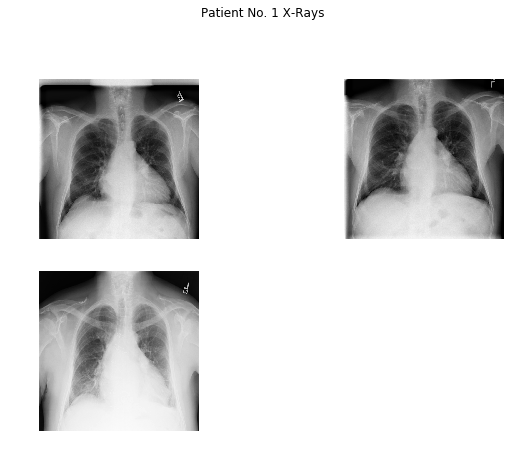

In [57]:
show_patient_xrays(1)

<p>These look great. However, since I'm not a doctor I'm not sure what might be going wrong in them. For now we'll ignore the bounding boxes to localize regions of interest, but I would like to get some labels on these images to be able to tell me exactly what a patient's prognosis is for a given xray.</p>

<p>We'll break out Pandas to check out what the csv that holds our labelling information looks like.</p>

In [77]:
label_path = 'data/Data_Entry_2017.csv'
label_df = pd.read_csv(
    label_path
)

In [78]:
print("==Category Information==")
categories = list(label_df)
for cat_ix, cat in enumerate(categories): 
    print("Category No. {}: {} ".format(cat_ix+1, cat))

==Category Information==
Category No. 1: img_ix 
Category No. 2: labels 
Category No. 3: follow_up_num 
Category No. 4: pat_id 
Category No. 5: pat_age 
Category No. 6: pat_gender 
Category No. 7: view_pos 
Category No. 8: o_img_w 
Category No. 9: o_img_h 
Category No. 10: o_img_spacing_x 
Category No. 11: o_img_spacing_y 


In [82]:
print("==Initial Look==")
label_df.head(100)

==Initial Look==


,img_ix,labels,follow_up_num,pat_id,pat_age,pat_gender,view_pos,o_img_w,o_img_h,o_img_spacing_x,o_img_spacing_y
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143


In [80]:
print("==Type Information==")
label_df.info()

==Type Information==
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 11 columns):
img_ix             112120 non-null object
labels             112120 non-null object
follow_up_num      112120 non-null int64
pat_id             112120 non-null int64
pat_age            112120 non-null int64
pat_gender         112120 non-null object
view_pos           112120 non-null object
o_img_w            112120 non-null int64
o_img_h            112120 non-null int64
o_img_spacing_x    112120 non-null float64
o_img_spacing_y    112120 non-null float64
dtypes: float64(2), int64(5), object(4)
memory usage: 9.4+ MB


In [81]:
print("==Descriptive Statistics==")
label_df.describe()

==Descriptive Statistics==


,follow_up_num,pat_id,pat_age,o_img_w,o_img_h,o_img_spacing_x,o_img_spacing_y
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800


<p>Ok, now that we have a grasp on the labeling data that we've got, we can look into actually labelling an x-ray image when we visualize it.</p>

In [148]:
def get_xray_labels(label_df, patient_no, xray_no):
    
    patient_no_pad = "{:08d}".format(patient_no)
    xray_no_pad = "{:03d}".format(xray_no)
    full_xray_id = patient_no_pad + '_' + xray_no_pad + '.png'
    
    xray_row = label_df[label_df['img_ix'] == full_xray_id]    
        
    labels = str(xray_row['labels']).split()[1]
    
    disease_list = labels.split('|')
    
    return disease_list


In [207]:
def show_labeled_xray(patient_no, xray_no, label_df):
    
    patient_no_pad = "{:08d}".format(patient_no)
    xray_no_pad = "{:03d}".format(xray_no)
    
    patient_string = patient_no_pad + '_' + xray_no_pad + '.png'
    image_path = 'data/images/' + patient_string
    
    xray_image = PIL.Image.open(image_path)
    
    fig = plt.figure(figsize=(10,10))
    
    plt.imshow(xray_image, cmap='gray')
    plt.axis('off')
    plt.title('Patient No. {} - Xray No. {}'.format(patient_no, xray_no))
    
    disease_list = get_xray_labels(
        label_df=label_df, 
        patient_no=patient_no, 
        xray_no=xray_no
    )
        
    fig.text(0.5,0.05, 'Diseases Present', ha='center', fontsize=14, fontweight='bold')
    for ix, disease in enumerate(disease_list):
        fig.text(0.5,-0.03*(ix), disease, ha='center')
    
    plt.show()

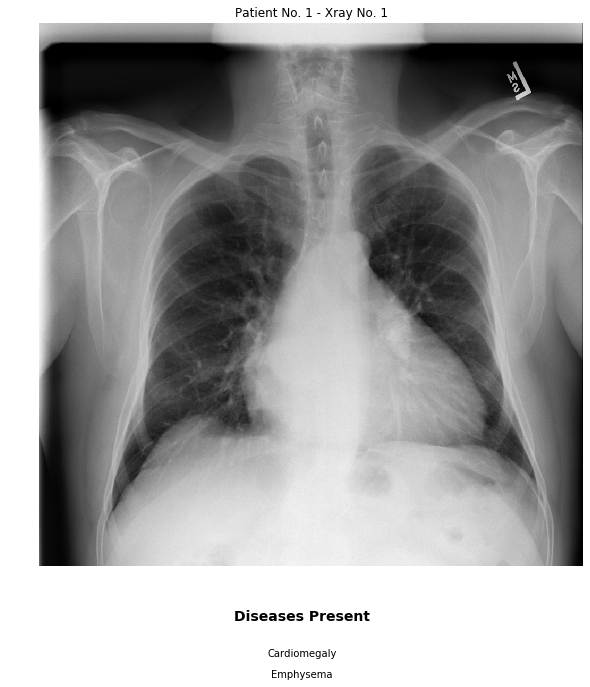

In [208]:
show_labeled_xray(1, 1, label_df)